<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 2. Full model fitting

This notebook describes fitting of a Bayesian hierarchical model of the effects of control (growth) and treatment (passage) on individual genes from *E. coli* DH10B (carrier) and Sakai (BAC load), to data obtained using a multi-*E. coli* microarray.

Much of the code for the visualisation, analysis and data manipulation of the fitting results is found in the associated Python module `tools.py`, which should also be present in this directory.

## Table of Contents

 1. [Experiment summary and interpretation](#summary)
 2. [Building the model](#building)
    1. [Stan model construction](#build_stan)
    2. [Define and fit the Stan model](#fit_stan)    
    3. [Extract the fit](#extract_stan)
 3. [Inspecting the fit](#inspect_fit)
    1. [Median parameter estimates](#median_estimates)
 4. [Identifying locus tags that confer an advantage under treatment](#locus_tags)
    1. [Plotting distribution of effects](#plot_effects)
    2. [Identifying candidates](#candidates)

## Experiment summary and interpretation <a id="summary">

The experiment involves measuring changes in microarray probe intensity before and after a pool of bacteria are subjected to one of two processes:

1. a sample from the pool is grown in media to a defined OD, then subsampled. This growth/subsample process is repeated *n* times. [*control*]
2. a sample from the pool is applied to plant leaves, subsampled, and that subsample grown in media to a defined OD, then subsampled. This passage/subsample/growth/subsample process is repeated *n* times. [*treatment*]

In a single replicate, the microarray is exposed to genomic DNA extracted from the pool (i) before the experiment begins, and (ii) after the experiment concludes. Three replicates were performed.

<br /><div class="alert-success">
**All genes in all samples go through the *growth and subsampling* part of the experiment, and we wish to estimate the effect of *passage and subsampling* on individual genes.**
</div>

The pool of bacteria comprises isolates of *E. coli* DH10B as a carrier organism. These isolates also contain BACs encoding random stretches of the *E. coli* Sakai chromosome. We therefore expect carrier organism genes to be unaffected by passage (treatment), and for any effects to be detectable only for genes that originate from *E. coli* Sakai.

We expect that genes conferring a phenotypic/selective advantage only for association with the plant should be enriched at the end of the treatment experiment, but not at the end of the control experiment. Sakai genes that are enriched in both treatment and control experiments may be generally advantageous for growth. 

<br /><div class="alert-danger">
**As the BACs describe contiguous regions of the *E. coli* Sakai genome, there is the possibility that linkage disequilibrium could result in some genes that do not confer an advantage by themselves apparently displaying enrichment after treatment.**
</div>

If the biological function conferring an advantage during passage is encoded by a suite of coregulated genes in an operon, we might expect all members of this suite to show evidence of enrichment after passage. It is likely that clusters of enrichment post-passage will be seen in the results. Although we are not accounting for this clustering or association by operon directly in the model, it is a possible additional hierarchical term in future iterations of our model.

We should expect there to be a selective burden to the carriage of additional non-functional gDNA as BACs, so we might anticipate a slightly negative effect under *control* conditions.

## Python imports

In [1]:
%pylab inline

import os

import numpy as np
import pandas as pd
import pickle
import pystan
import scipy
import seaborn as sns

import tools

import warnings
warnings.filterwarnings('ignore')

from Bio import SeqIO

sns.set_context('notebook')

Populating the interactive namespace from numpy and matplotlib


/Users/lpritc/Development/GitHub/Supplementary_Info/SI_Holmes_etal_2016/venv-SI_Holmes_2016/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


## Building the model <a id="building">

We assume that each array probe $i$ measures the quantity of genomic DNA in the sample that corresponds to a single gene $j[i]$. There may be multiple probes relating to a single gene, so it is possible that $j[p] = j[q], p \neq q$. <div class="alert-success">**This establishes a basis for pooling probe-level effects as samples of the gene-level effect.**</div>

We define the (input) measurement of a probe before an experiment as $x_i$, and the (output) measurement of that probe after the experiment as $y_i$. We assume that the measurement of each probe is subject to random experimental/measurement error that is normally-distributed with mean zero and variance $\sigma_y^2$. The actual quantity of DNA measured after the experiment can then be represented as $\hat{y}$, and the irreducible error in this measurement as $\epsilon$.

$$y_i = \hat{y_i} + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma_y^2) \implies y_i \sim N(\hat{y_i}, \sigma_y^2)$$

The relationship between the input and output DNA quantities measured by a single probe can be represented as $\hat{y_i} = f(x_i)$. That is to say, that the measured input DNA quantity $x_i$ is a *predictor* of the output quantity. This relationship will be modelled as the sum of two linear effects:

$$\textrm{control effect} = \alpha + \beta x$$
$$\textrm{treatment effect} = \gamma + \delta x$$
$$\hat{y_i} = \textrm{control effect}(x_i) + \textrm{treatment effect}(x_i) = \alpha + \beta x_i + \gamma + \delta x_i$$

<br /><div class="alert-success">
As these are linear effects, we have intercept/offset parameters ($\alpha$, $\gamma$) and gradient/slope parameters ($\beta$, $\delta$). Where $\beta$ or $\delta$ are large, they would indicate large $x_i$-dependent effects of the control (growth) and treatment (passage) parts of the experiment respectively.

As formulated above, the four parameters would be identical for all probes, but we are interested in estimating the control and treatment effects for individual genes, so we require a set of parameters for the gene that corresponds to probe $i$: $j[i]$. This is appropriate for the effects of growth/treatment that are specific to the levels of a single gene: $\beta$ and $\delta$.

The remaining parameters $\alpha$ and $\gamma$, the offsets from zero for each probe, could be considered to be constant across each experiment. They are possibly more realistically considered to be different for each array, i.e. each combination of replicate and treatment: $k$.
</div>

As a result, we estimate $\alpha_k$, $\beta_{j[i]}$, $\gamma_k$, $\delta_{j[i]}$, and the relationship for each probe is modelled as:

$$\hat{y_i} = \textrm{control effect}_{j[i]}(x_i) + \textrm{treatment effect}_{j[i]}(x_i) = \alpha_k + \beta_{j[i]} x_i + \gamma_[k] + \delta_{j[i]} x_i$$

The parameters $\alpha_k$, $\beta_{j[i]}$, $\gamma_k$, $\delta_{j[i]}$ (and $\epsilon_i$) are to be estimated by the model fit. 

<br /><div class="alert-success">
We assume that the values of each parameter, e.g. $\alpha_k$, are drawn from a single *pooled distribution* for that parameter, $\alpha \sim \textrm{some distribution}$. This ensures that our fits are not completely pooled as a single estimate $\alpha_k = \alpha$, which would imply that all parameter estimates are constant for all genes/arrays, a situation that would be completely uninformative for our goal to identify gene-level effects, and which would *underfit* our model. It also means that our estimates are not completely unpooled, which would allow all parameter estimates to vary independently. That situation would be equivalent to simultaneously fitting independent linear relationships to each gene, and so risk *overfitting* our model.
</div>

<br /><div class="alert-warning">
By using a *pooled distribution*, we allow a parameter estimate for each gene to influence the estimates of that parameter for all other genes in the experiment, constrained by an expected distribution of that parameter's values. To do this, we define a *prior distribution* for each parameter, but we do not specify its mean or variance, allowing the parameters of these *pooled distributions* also to be estimated in our model. 
</div>

For each parameter's *prior* we choose a Cauchy distribution, because it has fat tails and infinite variance. This does not constrain outlying and extreme values (those we are interested in) so much as other distributions (e.g. Normal or Student's *t*):

$$\alpha_k \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_k \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$

Each parameter's prior distribution requires a fit of both its mean and variance, and these also become parameters in our model. The means are free to vary, but we assume that the variance of each parameter's prior can be drawn from a Uniform distribution on the range (0, 100):

$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$

<div class="alert-success">
**We therefore construct the following model of the experiment:**

$$\hat{y_i} = \alpha_k + \beta_{j[i]} x_i + \gamma_k t_i + \delta_{j[i]} t_i x_i$$
$$y_i \sim N(\hat{y_i}, \sigma_y^2)$$
$$\alpha_k \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta_{j[i]} \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma_k \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta_{j[i]} \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\sigma_{\alpha} \sim U(0, 100)$$
$$\sigma_{\beta} \sim U(0, 100)$$
$$\sigma_{\gamma} \sim U(0, 100)$$
$$\sigma_{\delta} \sim U(0, 100)$$
$$\sigma_y \sim U(0, \infty)$$

<ul>
<li> $y_i$: measured intensity output on the array for probe $i$ (specific to each replicate)
<li> $x_i$: measured intensity input on the array for probe $i$ (specific to each replicate)
<li> $t_i$: 0/1 pseudovariable indicating whether the probe $i$ was measured in a control (0) or treatment (1) experiment
<li> $\alpha_k$: control effect offset for treatment X replicate $k$
<li> $\mu_{\alpha}$: mean control effect offset for all genes
<li> $\sigma_{\alpha}$: control effect offset variance for all genes
<li> $\beta_{j[i]}$: control effect slope for gene $[j[i]$
<li> $\mu_{\beta}$: mean control effect slope for all genes
<li> $\sigma_{\beta}$: control effect slope variance for all genes
<li> $\gamma_k$: treatment effect offset for treatment X replicate $k$
<li> $\mu_{\gamma}$: mean treatment effect offset for all genes
<li> $\sigma_{\gamma}$: treatment effect offset variance for all genes
<li> $\delta_{j[i]}$: treatment effect slope for gene $j[i]$
<li> $\mu_{\delta}$: mean treatment effect slope for all genes
<li> $\sigma_{\delta}$: treatment effect slope variance for all genes
<li> $\epsilon_i$: error in the model prediction for probe $i$
</ul>
</div>

### Load input data for fit

In the cells below we load in the data to be fit, and define useful variables for inspecting/analysing the data later:

* `locus_tags`: the unique locus tags represented in the dataset
* `ntags`: the number of unique locus tags
* `outdir`: path to the directory in which to place model fit output
* `outfile`: path to the model fit output file (pickled dataframe)

In [2]:
# load clean, normalised, indexed data
data = pd.read_csv("datasets/normalised_array_data.tab", sep="\t")  # full dataset
#data = pd.read_csv("datasets/reduced_locus_data.tab", sep="\t")  # reduced dataset
#data = data[:100]

# useful values
locus_tags = data['locus_tag'].unique()
ntags = len(locus_tags)
arrays = data['repXtrt'].unique()
narrays = len(arrays)

In [3]:
# Create output directory and filename to hold the fitted model
outdir = "model_fits"
os.makedirs(outdir, exist_ok=True)
outfile = os.path.join(outdir, 'modified_model_fit.pkl')

In [4]:
# Inserted to cut down model for testing

# Restrict data to certain locustags
#lt_filter = ['ECs0218', 'ECs0237']
#data = tools.reduce_dataset_by_column_value(data, 'locus_tag', lt_filter)

# useful values
#locus_tags = data['locus_tag'].unique()
#ntags = len(locus_tags)
#arrays = data['repXtrt'].unique()
#narrays = len(arrays)

# change output pickle
#outfile = os.path.join(outdir, 'test_model_fit.pkl')

### Stan model construction <a id="build_stan">

We need to define `data`, `parameters` and our `model` for `Stan`.

<br /><div class="alert-success">
In the `data` block, we have:

<ul>
<li> `N`: `int`, the number of data points
<li> `J`: `int`, the number of unique locus tags (`J` < `N`)
<li> `K`: `int`, the number of unique treatment X replicate combinations (arrays)
<li> `array`: `int[N]`, an index list of arrays
<li> `tag`: `int[N]`, an index list of locus tags
<li> `t`: `vector[N]`, 0/1 control/treatment values for each probe
<li> `x`: `vector[N]`, the input log(intensity) values
<li> `y`: `vector[N]`, the output log(intensity) values
</ul>

In the `parameter` block, we have:

<ul>
<li> `a`: `real vector[K]`, estimated offset effect on log(intensity) of the *control* for each array
<li> `mu_a`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the *control* effect offset, for all arrays
<li> `sigma_a`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the *control* effect offset, for all arrays
<li> `b`: `real vector[J]`, estimated slope effect on log(intensity) of the *control* for each locus tag/gene
<li> `mu_b`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the *control* effect slope, for all locus tags
<li> `sigma_b`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the *control* effect slope, for all locus tags
<li> `g`: `real vector[K]`, estimate of the influence of treatment on the output measured intensity (offset) for array
<li> `mu_g`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the offset for all arrays due to *treatment*
<li> `sigma_g`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the offset for all arrays due to *treatment*
<li> `d`: `real vector[J]`, estimate of the influence of treatment on the output measured intensity (slope) for each locus tag/gene
<li> `mu_d`: `real`, an unconstrained value to be fit that represents the mean of the Cauchy distribution for the slope for all locus tags due to *treatment*
<li> `sigma_d`: `real<lower=0,upper=100>`, standard deviation of the Cauchy distribution for the slope for all locus tags due to *treatment*
<li> `sigma`: `real<lower=0>`, the error in the prediction
</ul>

We also define a `transformed parameter`:

<ul>
<li> `y_hat[i] <- b[tag[i]] * x[i] + a[array[i]] + g[tag[i]] * t[i] + d[array[i]] * t[i] * x[i]`: the linear relationship describing $\hat{y}$, our estimate of experimental output intensity, which is subject to variance `sigma`.
</ul>
</div>

### Define and fit the Stan model <a id="fit_stan">

In the cells below we define the model to be fit, in the Stan language, conduct the fit, and save the fit out to a pickled dataframe>

In [5]:
# define unpooled stan model
treatment_model = """
data {
  int<lower=0> N;
  int<lower=0> J;
  int<lower=0> K;  
  int<lower=1, upper=J> tag[N];
  int<lower=1, upper=K> array[N];  
  vector[N] t;
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[K] a;
  vector[J] b;
  vector[K] g;
  vector[J] d;
  real mu_a;
  real mu_b;
  real mu_g;
  real mu_d;
  real<lower=0> sigma;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_g;
  real<lower=0,upper=100> sigma_d;
}
transformed parameters{
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] = a[array[i]] + b[tag[i]] * x[i] + g[array[i]] * t[i] + d[tag[i]] * t[i] * x[i];
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ cauchy(mu_a, sigma_a);

  sigma_b ~ uniform(0, 100);
  b ~ cauchy(mu_b, sigma_b);

  sigma_g ~ uniform(0, 100);
  g ~ cauchy(mu_g, sigma_g);

  sigma_d ~ uniform(0, 100);
  d ~ cauchy(mu_d, sigma_d);

  y ~ normal(y_hat, sigma);
}
"""

In [6]:
# relate python variables to stan variables
treatment_data_dict = {'N': len(data),
                       'J': ntags,
                       'K': narrays,
                       'tag': data['locus_tag_index'] + 1,
                       'array': data['repXtrt_index'] + 1,
                       't': data['treatment'],
                       'x': data['log_input'],
                       'y': data['log_output']}

In [7]:
treatment_data_dict['array'].unique()

array([1, 2, 3, 4, 5, 6])

In [8]:
# run stan fit
#treatment_fit = pystan.stan(model_code=treatment_model,
#                            data=treatment_data_dict,
#                            iter=1000, chains=2,
#                            seed=tools.SEED)

In [9]:
# Save model to file, for reuse# Save fit to file, for reuse
#unpermutedChains = treatment_fit.extract()
#unpermutedChains_df = pd.DataFrame([dict(unpermutedChains)])
#pickle.dump(unpermutedChains_df, open(outfile, 'wb'))

### Extract the fit <a id="extract_stan">

<br /><div class="alert-warning">
**In the cells below we load in the contents of the pickled output (if the fit has already been run), and then extract useful summary information about mean, median, variance, and credibility intervals for the parameter estimates.**
</div>

<br /><div class="alert-success">
<ul>
<li> parameters $\alpha$, $\beta$, $\gamma$ and $\delta$ are represented by their Roman letter equivalents `a`, `b`, `g` and `d`.
<li> `*_mean` and `*_median` are the mean and median estimates for the parameter over the ensemble
<li> `*_sem` is the standard deviation for the parameter estimate over the ensemble
<li> `*_Npc` is the *N*th percentile for the parameter estimate, over the ensemble. These can be combined to obtain credibility intervals (e.g. the range `a_25pc`-`a_75pc` constitutes the 50% CI for $\alpha_{j[i]}$.
</div>

In [10]:
# Uncomment the line below to import the previously-fit model
treatment_fit = pickle.load(open(outfile, 'rb'))

In [11]:
#data
treatment_fit

,a,b,d,g,lp__,mu_a,mu_b,mu_d,mu_g,sigma,sigma_a,sigma_b,sigma_d,sigma_g,y_hat
0,"[[0.232524877366, 0.2519720541, 0.220762417876...","[[0.449762946122, 0.648895406848, 0.5536611675...","[[-0.323007227878, -0.623360061742, -0.3336907...","[[-0.16519143644, 0.398807121804, 0.4465240338...","[54478.0128609, 54369.6498199, 54357.6675201, ...","[0.280212553305, 0.235517874389, 0.27967110855...","[0.950578582089, 0.950291822951, 0.94740956847...","[-0.0632984483227, -0.0583518700068, -0.054803...","[0.426624344987, 0.439776548491, 0.36943274761...","[0.470990845178, 0.470628935352, 0.47244577200...","[0.128919029758, 0.0221191773281, 0.0138330862...","[0.00664239995603, 0.00648767802188, 0.0070776...","[0.0078670536189, 0.00784427674846, 0.00767769...","[0.124641903237, 0.186763125551, 0.00348271737...","[[1.39823549793, 1.11513324048, 2.46494956303,..."


In [12]:
len(treatment_fit['a'][0][0])

6

In [13]:
# Get summary data for parameter estimates
# use 'fit' for the model fit directly, and 'df'for loaded pickled data
estimates = tools.extract_variable_summaries(treatment_fit, 'df',
                                             ['a', 'b', 'g', 'd'],
                                             [arrays, locus_tags, arrays, locus_tags])
estimates.head()  # inspect the data

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
0,ECDH10B_RS00010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.907909,0.932580,...,NaN,NaN,NaN,-0.106789,-0.065958,-0.048565,-0.023847,-0.058070,-0.057542,0.019050
1,ECDH10B_RS00020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914396,0.934645,...,NaN,NaN,NaN,-0.085109,-0.064664,-0.046774,-0.025243,-0.055638,-0.057188,0.015163
2,ECDH10B_RS00060,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.914911,0.935482,...,NaN,NaN,NaN,-0.105381,-0.067194,-0.045122,-0.014049,-0.057540,-0.057505,0.021189
3,ECDH10B_RS00065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.912512,0.935084,...,NaN,NaN,NaN,-0.092378,-0.063993,-0.044987,-0.020414,-0.055270,-0.056006,0.017903
4,ECDH10B_RS00070,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.901806,0.934273,...,NaN,NaN,NaN,-0.098637,-0.066353,-0.045173,-0.022492,-0.057138,-0.057634,0.018181


In [14]:
#estimates.loc[estimates['locus_tag'].isin(lt_filter)]
estimates.loc[estimates['d_25pc'] > 0]

,locus_tag,a_2.5pc,a_25pc,a_75pc,a_97.5pc,a_mean,a_median,a_sem,b_2.5pc,b_25pc,...,g_mean,g_median,g_sem,d_2.5pc,d_25pc,d_75pc,d_97.5pc,d_mean,d_median,d_sem
2397,ECs0415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.868372,0.928768,...,NaN,NaN,NaN,-0.056614,0.138136,0.325986,0.470599,0.224186,0.235389,0.140639
2398,ECs0416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.835985,0.912878,...,NaN,NaN,NaN,-0.059069,0.089735,0.239756,0.351637,0.159549,0.174705,0.113322
2896,ECs1121,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.919084,0.938050,...,NaN,NaN,NaN,-0.056744,0.010866,0.091492,0.152473,0.051035,0.057269,0.057476
2919,ECs1161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918270,0.937893,...,NaN,NaN,NaN,0.047905,0.170386,0.297448,0.406220,0.232653,0.237648,0.091481
2994,ECs1262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878069,0.921825,...,NaN,NaN,NaN,0.075830,0.160284,0.238485,0.304142,0.197766,0.197020,0.057731
3002,ECs1272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.912198,0.933089,...,NaN,NaN,NaN,0.021674,0.094067,0.167541,0.233572,0.130196,0.130858,0.053677
3003,ECs1273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.898451,0.936025,...,NaN,NaN,NaN,0.056814,0.133825,0.209449,0.295518,0.171800,0.169504,0.058780
3004,ECs1274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.901472,0.930982,...,NaN,NaN,NaN,-0.008508,0.097674,0.170603,0.246627,0.132339,0.134231,0.058922
3005,ECs1275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.900911,0.930887,...,NaN,NaN,NaN,-0.040345,0.063393,0.139716,0.204450,0.098592,0.101744,0.060264
3006,ECs1276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.904818,0.930919,...,NaN,NaN,NaN,0.043961,0.100221,0.165018,0.224457,0.133465,0.135400,0.045865


In [15]:
# Separate estimates for Sakai and DH10B into two different dataframes
sakai_estimates = tools.split_estimates(estimates, 'sakai')
dh10b_estimates = tools.split_estimates(estimates, 'dh10b')

## Inspecting the fit <a id="inspect_fit">

In the cells below, we visualise the fitted estimates for each of the parameters $\alpha$, $\beta$, $\gamma$, and $\delta$ as:

* box plots of median estimates for each locus tag
* relationship between control and treatment effects in Sakai
* plots of 50% credibility interval range and median estimate for each locus tag

### Median parameter estimates <a id="median_estimates">

We first inspect the range of fitted estimates to get an overview of the relationships for the data as a whole, and then examine whether this relationship varies by *E. coli* isolate.

Making boxplots for the full set of fitted parameter estimates, for both isolates:

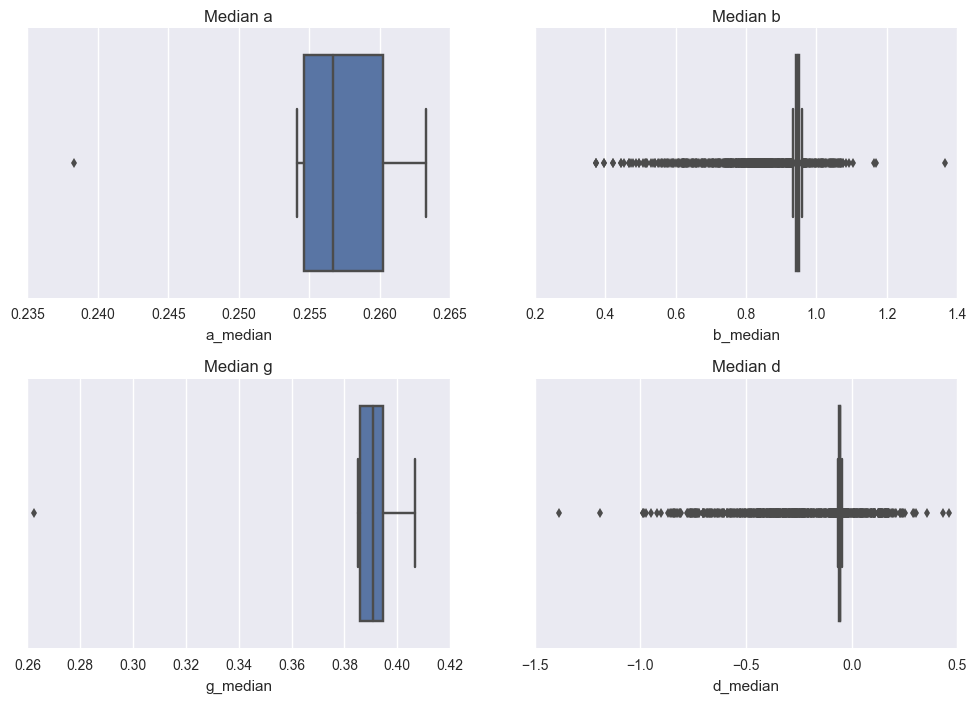

In [16]:
# Visualise median values for parameter estimates
tools.boxplot_medians(estimates)

<br /><div class="alert-success">
For this fit we can see that most estimated (median) values of $\alpha$ (control intercept), $\gamma$ (treatment intercept), and $\delta$ (treatment slope) are close to zero. Most estimated values of $\beta$ are close to (but slightly less than) unity. **This implies that:**

<ul>
<li> **The linear relationship between input and output intensity due to the control effects (growth only) is, for most genes in the experiment, a slight reduction of output intensity with respect to input intensity value, and on the whole the effect of the control is neutral [median $\alpha$ ≈ 0, median $\beta$ ≈ 1]**
<li> **For most genes in the experiment there is no treatment effect due to exposure to the plant [median $\gamma$ ≈ 0, median $\delta$ ≈ 0]**
</ul>
</div>

<br /><div class="alert-warning">
There are, however, a considerable number of outlying median values for each parameter, which suggests that a number of genes have associated parameter values that are affected by either control (growth) or treatment (passage).
</div>

#### DH10B

Considering boxplots of estimated parameters for the DH10B (carrier) isolate only:

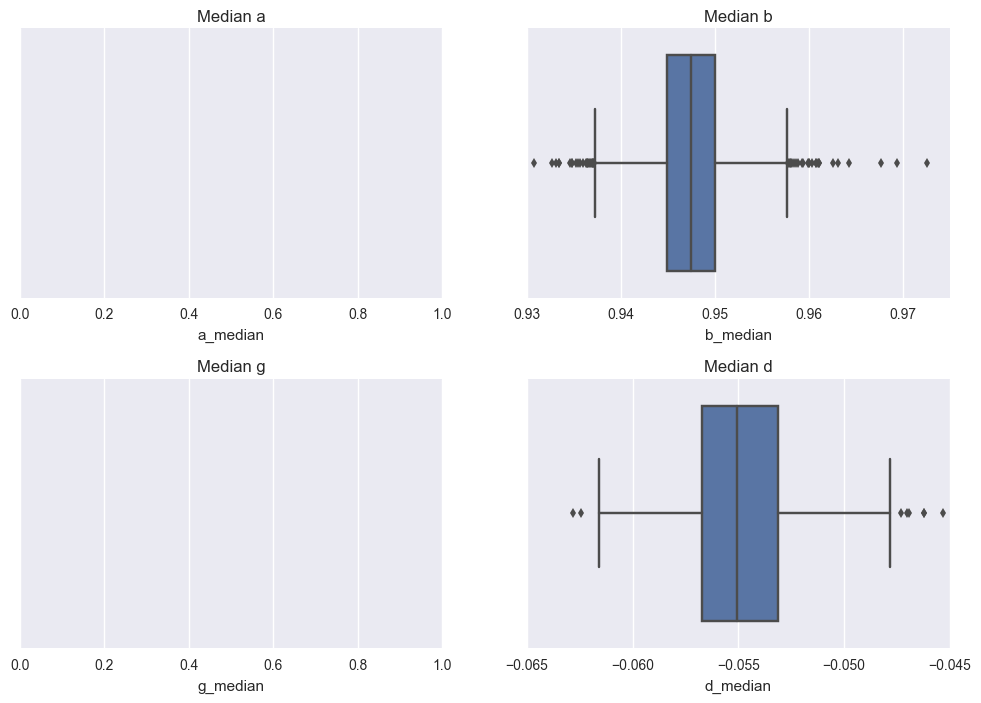

In [17]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(dh10b_estimates)

it is clear that the median parameter estimates for DH10B are extremely restricted in their range:

* $0.2 < \alpha < 0.5$
* $0.936 < \beta < 0.95$
* $0.36 < \gamma < 0.43$
* $-0.061 < \delta < 0.06$

<br /><div class="alert-success">
The control effect appears to be essentially *neutral*, in that the output intensity is almost a 1:1 linear relationship with the input intensity, but it is striking that the median estimates of $\gamma$ and $\delta$ are very close to zero, suggesting that passage (treatment) has almost no effect on this relationship, for any DH10B locus tag.

**This is exactly what would be expected for DH10B as the carrier isolate.**
</div>

#### Sakai

Considering the Sakai isolate parameter estimates only:

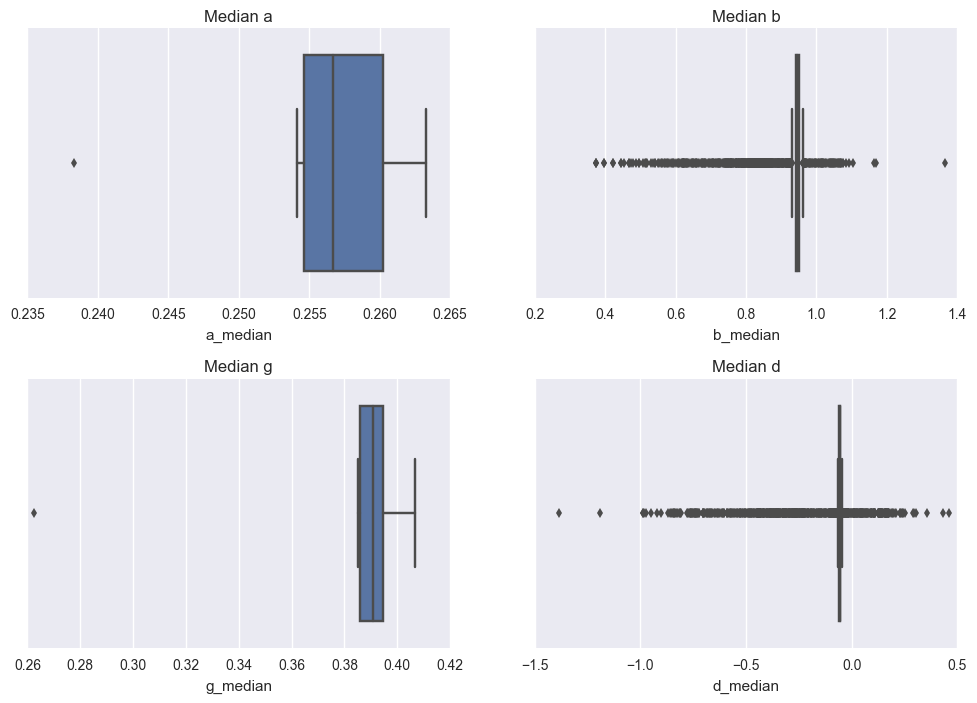

In [18]:
# Visualise median values for Sakai parameter estimates
tools.boxplot_medians(sakai_estimates)

By contrast to the results for DH10B, the median parameter estimates for Sakai have many large value outliers, though the bulk of estimates are close to the values seen for DH10B:

* $-20 < \alpha < 10$
* $-1 < \beta < 3.5$
* $-30 < \gamma < 30$
* $-6 < \delta < 8$

<br /><div class="alert-success">
This indicates that we see our expected result, that strong variability of control and treatment effects are effectively confined to the Sakai BAC fragments.

**It is expected that some genes/operons may be relatively advantageous in either growth (control) or passage (treatment) conditions, or both.**
</div>

We can visualise the relationships between parameter estimates for control and treatment effects in scatterplots.

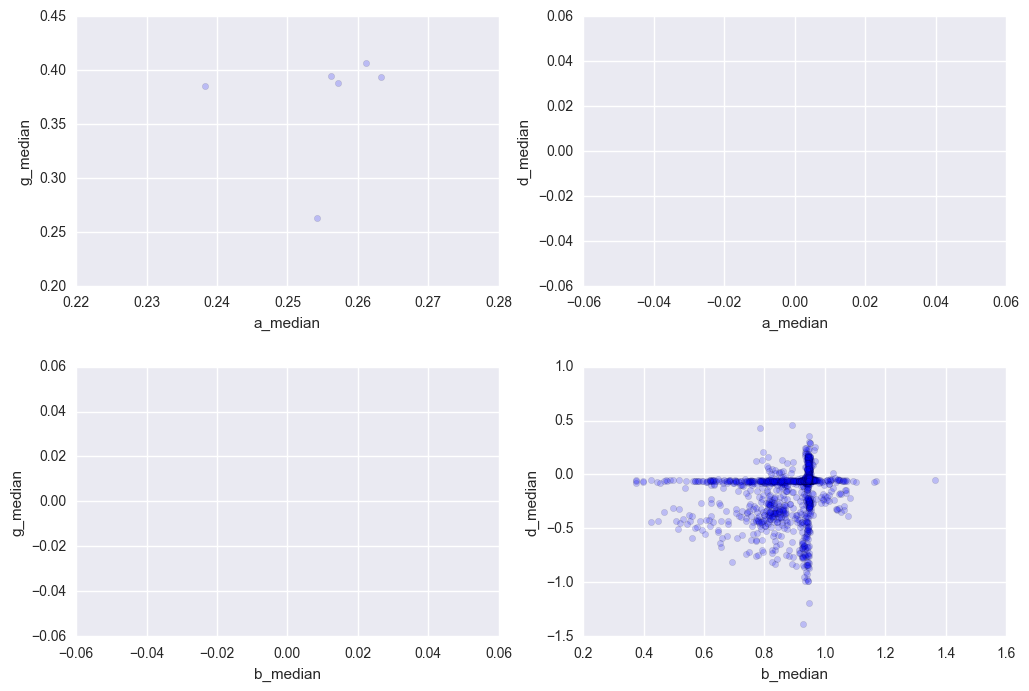

In [19]:
# Plot estimated parameters for treatment effects against control effects for Sakai
tools.plot_treatment_vs_control(sakai_estimates)

<br /><div class="alert-warning">
The strong cross-like distributions indicate that most parameter estimates that vary from those of the bulk do so orthogonally in either *treatment* or *control* conditions: deviation of the control experiment parameters is not strongly associated with deviation of the treatment effect parameters, and relatively few Sakai genes confer a selective advantage or disadvantage under both conditions.
<br /><br />
However, there is a group of estimates in the plots of `d_median` against `a_median` and `b_median` that suggest an additional effect is in play. Several locus tags with median estimates of $\delta \approx 1$ are also associated with large values of `b_median` and small values of `a_median`. This might reflect a situation where the variability in the estimates of control and treatment effects is large, and the (biologically meaningless) uncertainty is being partitioned across the parameter sets. Alternatively, it could indicate that there is genuinely a strong positive effect on the BAC-carrying organisms under both conditions.
</div>

To help determine whether this relationship is apparently artefactual (large variance is split across the parameter sets), or potentially meaningful, we can inspect whether the parameter estimates could reasonably include the median for the pooled parameter distribution, or zero.

We inspect this suspect group of locus tags directly, to examine whether the 95% credibility intervals for those parameter estimates include 1 (for $\beta$) or 0 (for $\delta$). If both CIs for a locus tag include these values, then we might consider that the median estimates are the result of partitioning noise across both estimates. Otherwise, we will treat the genes as having a meaningful signal under both control and treatment conditions.

In [20]:
# Extract the suspect locus tags which have large estimates for d_median and b_median
suspects = sakai_estimates.loc[(sakai_estimates['b_median'] > 1) &
                               (sakai_estimates['d_median'] > 0.5)]
suspects = suspects[['locus_tag',
                     'b_2.5pc', 'b_median', 'b_97.5pc',
                     'd_2.5pc', 'd_median', 'd_97.5pc']]
suspects['b_bulk'] = (suspects['b_2.5pc'] < 1) & (1 < suspects['b_97.5pc'])
suspects['d_bulk'] = (suspects['d_2.5pc'] < 0) & (0 < suspects['d_97.5pc'])
suspects['noise'] = (suspects['b_bulk'] | suspects['d_bulk'])
suspects

,locus_tag,b_2.5pc,b_median,b_97.5pc,d_2.5pc,d_median,d_97.5pc,b_bulk,d_bulk,noise


<br /><div class="alert-warning">
From the table that results, a few locus tags have parameter estimate variability that suggest they could take the value of the bulk of the population, for at least one of these parameters:

<ul>
<li> ECs0237
<li> ECs1556
<li> ECs3232
<li> ECs3233
<li> ECs3239
<li> ECs3242
<li> ECs3501
<li> ECs4330
<li> ECs4332
<li> ECs4338
<li> ECs4355
<li> ECs4356
</ul>
</div>

<br /><div class="alert-success">
Otherwise the 95% CI for each of the parameter estimates suggests we should have some confidence in their values being unusually large for both control and treatment effects, so potentially being genes that confer a general (not specifically plant-associated) advantage to the carrier isolate.
</div>

## Identifying locus tags that confer an advantage under treatment and/or control <a id="locus_tags">

We use a 50% credibility interval to determine whether the effect of a gene on passage is likely to be positive. Under this assumption, the middle 50% of the parameter estimates for $\delta$ do not include zero for those genes that confer a selective advantage in passage/*treatment* (i.e. we require our estimate to be credibly positive). We label these `trt_pos`.

Likewise, we use a 50% credibility interval to determine whether the effect of a gene on surviving growth (control) is an outlier. If the 50% CI for $\beta$ does not include the 97.5 percentile for all estimates of $\beta$ (as an upper estimate of overall dataset centrality) in this dataset, we consider that the effect of the gene on surviving growth conditions is positive. We label these `ctl_pos`.

We create a third category: `combined`: genes with an estimated positive effect on both growth and passage.

In [42]:
# Label locus tags with positive effects
sakai_estimates = tools.label_positive_effects(sakai_estimates)

# QUICK HACK (avoids repXtrt rows)
sakai_estimates = sakai_estimates.loc[:6083]

We can count the number of locus_tags in each of the groups:

In [43]:
# Count locus tags in each of the positive groups
counts = [sum(sakai_estimates[col]) for col in ('trt_pos', 'ctl_pos', 'combined')]
print("treatment positive: {0}\ncontrol positive: {1}\nboth: {2}".format(*counts))

treatment positive: 115
control positive: 0
both: 0


<div class="alert-success">
which indicates, with these assumptions, that **72 genes have a credible positive effect on passage (treatment), 24 of these also have a credible positive effect in the growth (control) step, and a further 28 have a credible positive effect only on the growth step.**
</div>

### Plotting distribution of effects <a id="plot_effects">

We can show the estimated effects, and our confidence in those estimates, on a rough representation of the genome by plotting those values for each locus tag in genome order.

In the plots that follow, parameter estimates for each locus tag are rendered as points (the median estimate), with the 50% credibility interval for the estimate indicated as a line. If the 50% CI includes a threshold value - either the 97.5 percentile median value for the parameter estimate ($\beta$) or zero ($\delta$) - then we consider that there is not strong evidence of an effect due to that gene, and the interval is coloured blue.

If the interval does not include the corresponding threshold value, then it is coloured either green for a positive effect, or red for a negative effect.

#### Sakai

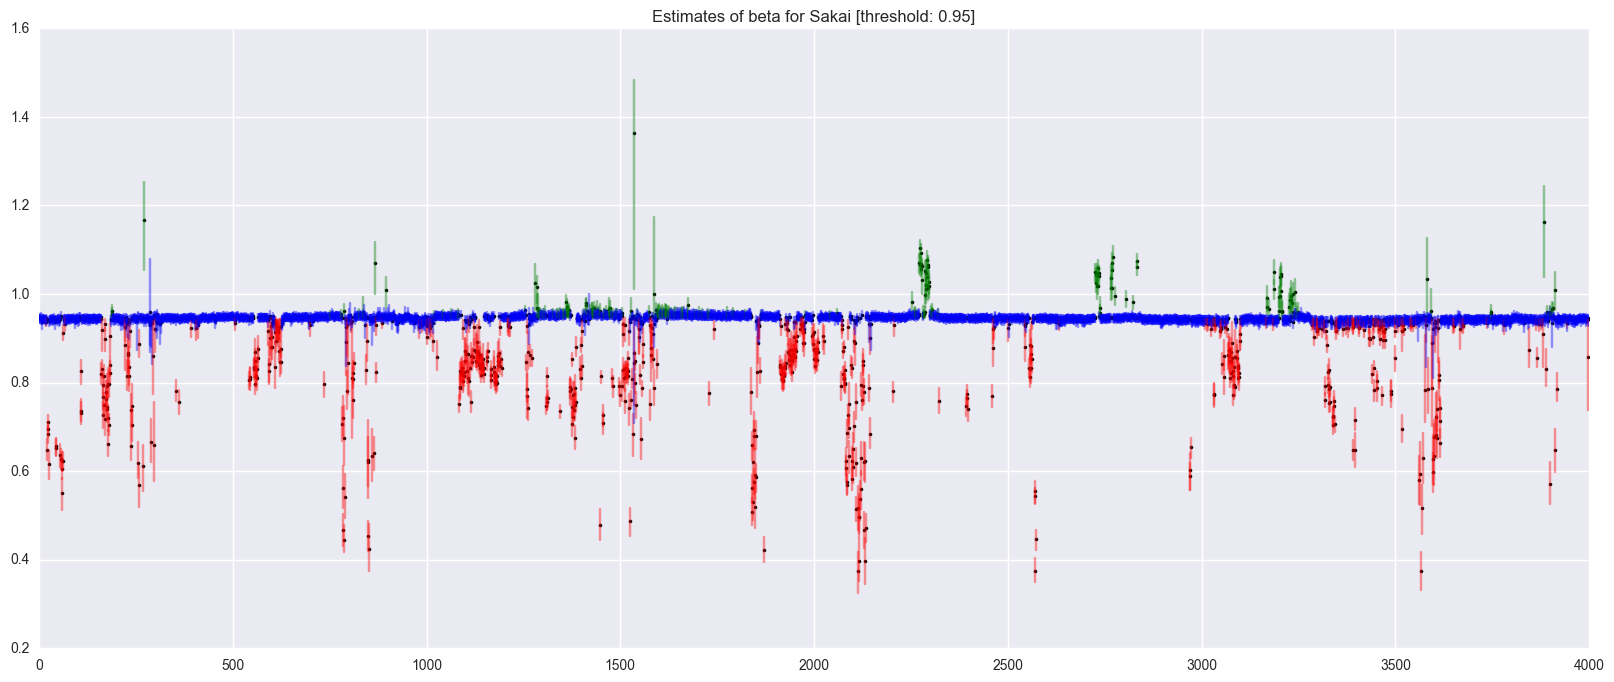

In [44]:
# Plot genome-wide estimates of beta for Sakai
beta_thresh = np.median(sakai_estimates['b_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(sakai_estimates, 'b', 'Estimates of beta for Sakai', beta_thresh)

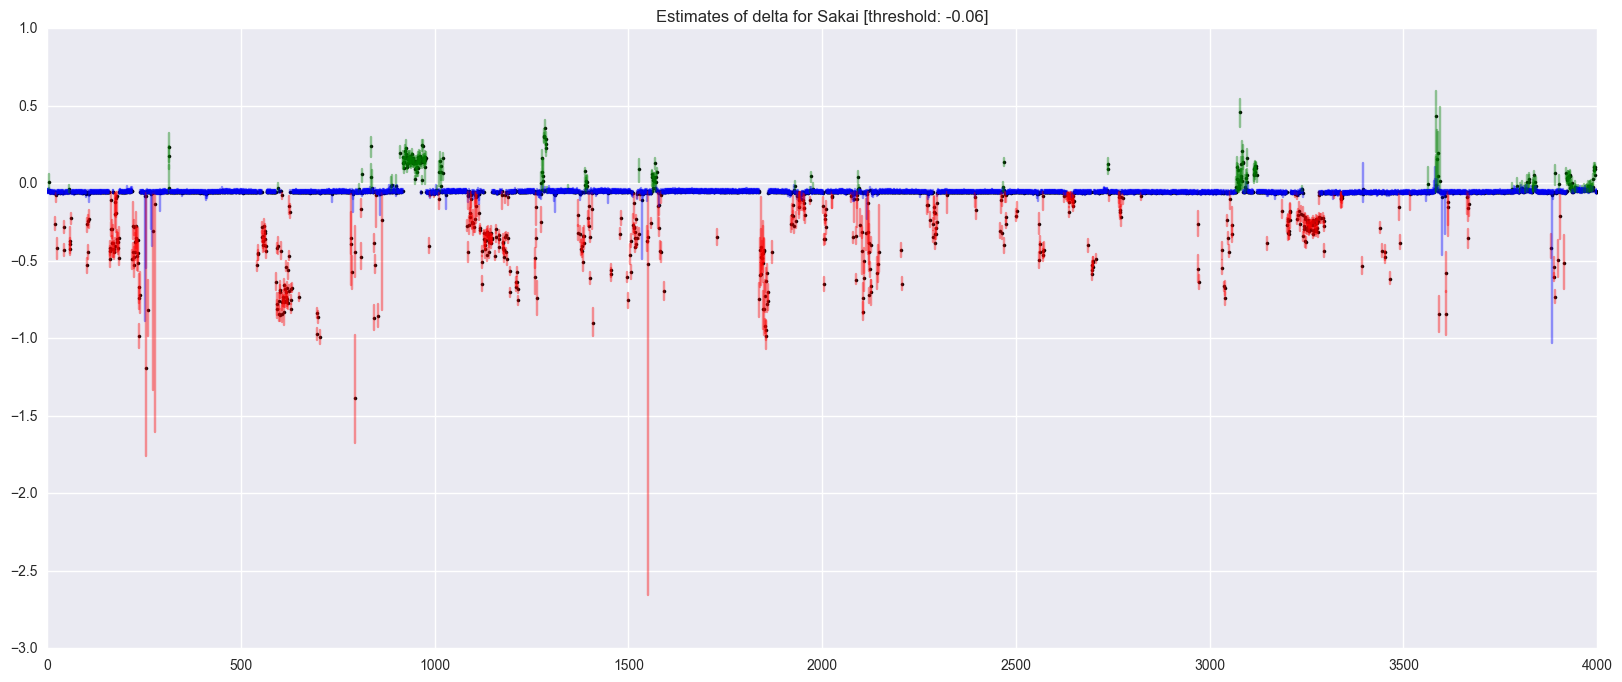

In [46]:
# Plot genome-wide estimates of delta for Sakai
delta_thresh = np.median(sakai_estimates['d_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(sakai_estimates, 'd', 'Estimates of delta for Sakai', delta_thresh)

<div class="alert-success">
These two plots indicate that most Sakai genes do not produce parameter estimates that are indicative of credible effects in the control or treatment, in either direction.
<br /><br />
Where effects are seen they tend to cluster on the genome, which is as would be expected if operons or gene clusters with common function were responsible for producing an effect. This is suggestive that we are measuring a biological effect, rather than noise.
<br /><br />
In general, several clusters of both positive and negative effects appear in both plots for effects due to control ($\beta$) and treatment ($\delta$). However, two groups of locus tags - at approximately 1000 units and 2500 units on the $x$-axis - appear to be uniquely showing credible positive effects only under the treatment condition,
</div>

#### DH10B

We plot similar representations for the DH10B isolate as a control, and see that all parameter estimates for this isolate's locus tags are very similar.

<br /><div class="alert-warning">
There is a weak sinusoidal pattern of fitted estimates. As no gene ordering information is available to the model fit, and there is an apparent symmetry to this pattern, it may reflect a real underlying biological process or structure.
</div>

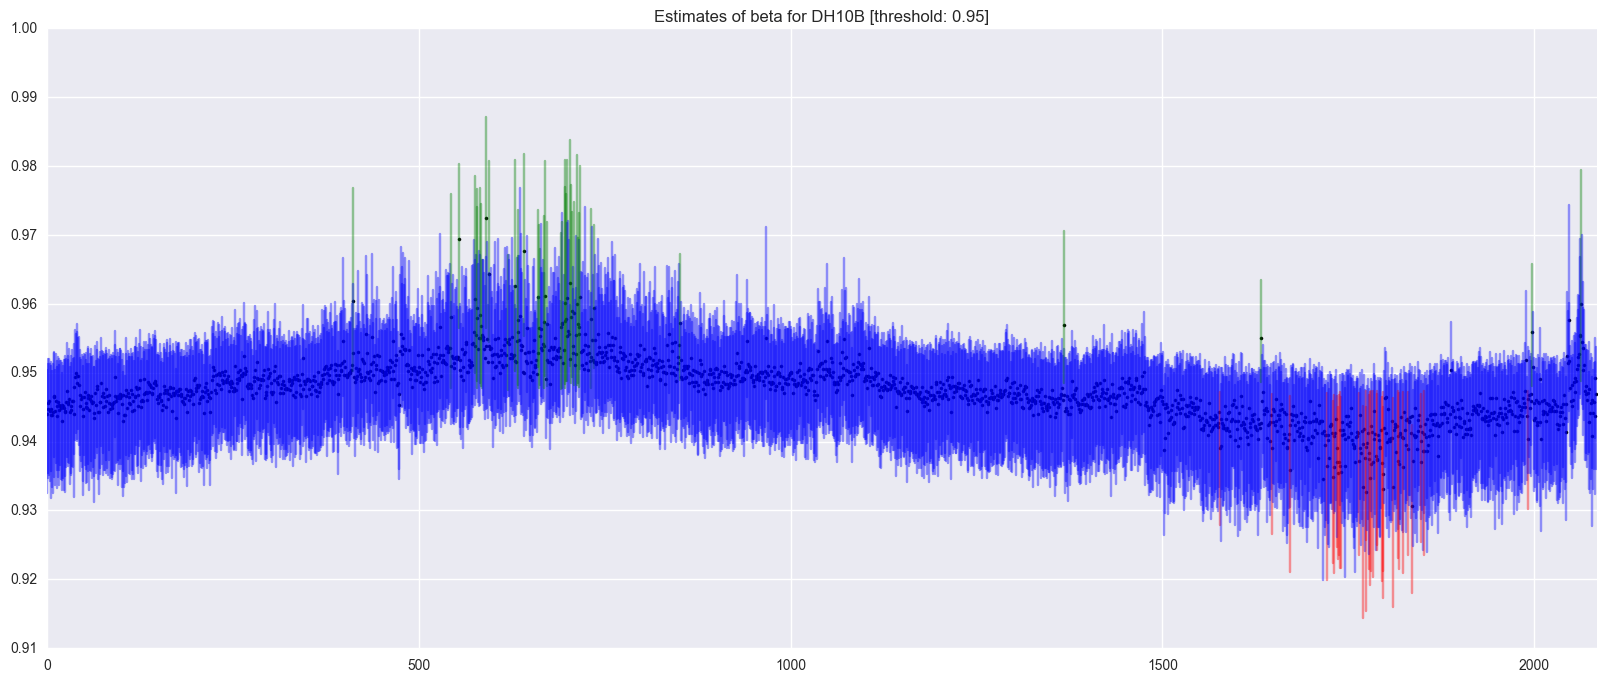

In [25]:
# Plot genome-wide estimates of beta for DH10B
beta_thresh = np.median(dh10b_estimates['b_median'])  # mark values that don't include the median beta in 50% CI
tools.plot_parameter(dh10b_estimates, 'b', 'Estimates of beta for DH10B', beta_thresh)

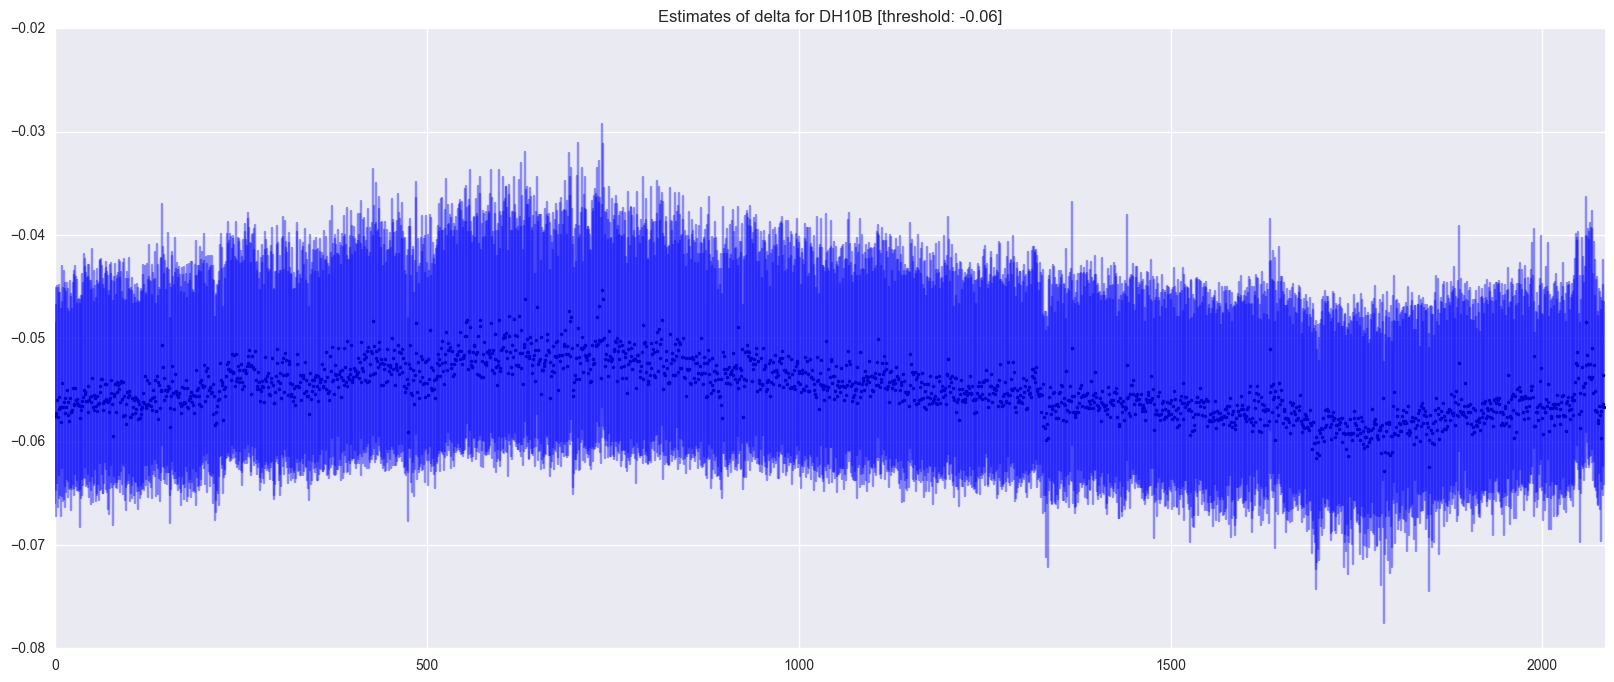

In [26]:
# Plot genome-wide estimates of delta for DH10B
delta_thresh = np.median(dh10b_estimates['d_median'])  # mark values that don't include the median delta in 50% CI
tools.plot_parameter(dh10b_estimates, 'd', 'Estimates of delta for DH10B', delta_thresh)

### Identifying candidates <a id="candidates">

With the information above, we can import functional information and list the genes/locus tags that appear to have a positive effect on either the control or treatment steps.

In [47]:
candidates = sakai_estimates[sakai_estimates['ctl_pos'] | sakai_estimates['trt_pos']]
candidates = candidates[['locus_tag',
                         'b_median', 'ctl_pos',
                         'd_median', 'trt_pos']].sort_values(['ctl_pos', 'trt_pos', 'locus_tag'])

We restrict these to the genes that have a credible effect only under treatment, identifying 48 genes with positive $\delta$ where the 50% CI does not include zero:

In [48]:
trt_only_positive = candidates.loc[candidates['trt_pos'] & ~candidates['ctl_pos']]
trt_only_positive.shape

(115, 5)

We add a column with the functional annotation of each of the candidates that appear to have a positive selective effect under treatment conditions:

In [60]:
annotated = tools.annotate_locus_tags(trt_only_positive,
                                      os.path.join('..', 'data', 'Sakai',
                                                   'GCA_000008865.1_ASM886v1_genomic.gbff'))
annotated

,locus_tag,b_median,ctl_pos,d_median,trt_pos,annotation
2397,ECs0415,0.943381,False,0.235389,True,putative periplasmic-iron-binding protein
2398,ECs0416,0.935728,False,0.174705,True,putative regulatory protein
2896,ECs1121,0.948441,False,0.057269,True,putative host specificity protein
2919,ECs1161,0.947319,False,0.237648,True,putative excisionase
2994,ECs1262,0.938215,False,0.197020,True,hypothetical protein
3002,ECs1272,0.943690,False,0.130858,True,Rtn-like protein
3003,ECs1273,0.945370,False,0.169504,True,FidL-like protein
3004,ECs1274,0.943394,False,0.134231,True,putative transcriptional regulator
3005,ECs1275,0.944433,False,0.101744,True,putative oxidoreductase
3006,ECs1276,0.943277,False,0.135400,True,putative chaperone protein


Merge original data with the predictions.

In [54]:
# Merge fit estimates with observed data
resultscols = ['locus_tag', 'probe', 'replicate', 'treatment',
               'log_input', 'log_output',
               'offset', 'b_median', 'd_median', 'annotation']
results_merged = pd.merge(annotated, data,
                          how='outer',
                          left_on='locus_tag', right_on='locus_tag').loc[:, resultscols]
results_merged['difference'] = results_merged['log_output'] - results_merged['log_input']
results_merged.head(12)

,locus_tag,probe,replicate,treatment,log_input,log_output,offset,b_median,d_median,annotation,difference
0,ECs0415,A_07_P043771,1,0,4.889754,4.853641,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,-0.036113
1,ECs0415,A_07_P043771,2,0,5.180048,4.776122,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,-0.403926
2,ECs0415,A_07_P043771,3,0,1.804380,1.994759,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,0.190379
3,ECs0415,A_07_P043771,1,1,2.376618,4.065896,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,1.689279
4,ECs0415,A_07_P043771,2,1,2.614676,3.582848,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,0.968172
5,ECs0415,A_07_P043771,3,1,-0.523139,0.405531,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,0.928670
6,ECs0415,A_07_P053966,1,0,4.935381,4.910987,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,-0.024394
7,ECs0415,A_07_P053966,2,0,5.537948,4.855196,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,-0.682751
8,ECs0415,A_07_P053966,3,0,2.388387,1.941498,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,-0.446889
9,ECs0415,A_07_P053966,1,1,2.350126,4.130794,NaN,0.943381,0.235389,putative periplasmic-iron-binding protein,1.780668


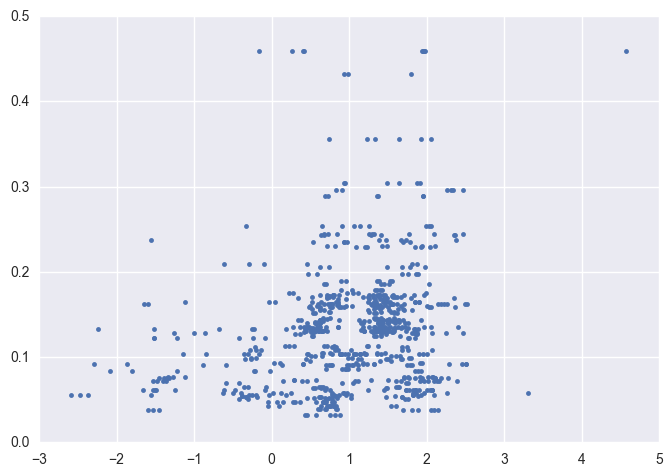

In [58]:
treatment_rows = results_merged.loc[results_merged['treatment'] == 1]
plot(treatment_rows['difference'], treatment_rows['d_median'], '.')

So, we have a situation where genes with an unequivocal drop in intensity across all probes are associated with a positive effect from treatment, which is not sensible. By visual inspection, this looks to be associated with a strong negative offset in one or both of $\alpha$ and $\gamma$.

This now looks like there might be a systematic problem with the model: individual offsets for each gene are perhaps not appropriate. Should we consider the offset to be associated with the specific array (i.e. a product of treatment x replicate), so there would be six estimates for the offset?

I'll generate a new model in a new notebook, to account for this.